In [1]:
%load_ext autoreload
%autoreload 2

In [102]:
import pandas as pd
import numpy as np
from math import floor
import logging
from datetime import datetime, timedelta
from functools import wraps
import time
import logging
from typing import Any, Dict, List, Callable
import re
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import hyperopt
from scipy.stats import ks_2samp
from sklearn.metrics import make_scorer, classification_report, confusion_matrix,roc_curve,auc,make_scorer,jaccard_score
from catboost import CatBoostClassifier, Pool
from sklearn.utils.class_weight import compute_sample_weight
import seaborn as sns
import shap
from tqdm import tqdm
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from catboost import CatBoostClassifier, Pool
import pickle
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import gc
from scipy.stats import ks_2samp
import hyperopt
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from scipy.stats import pointbiserialr
import scipy.stats as stats
import scikitplot as skplt

### Importando os dados

In [3]:
df = pd.read_csv(r"C:\Users\mf_ra\OneDrive\Escritorio\case_fleury\dataset.txt",sep=";")

Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.


In [4]:
df.head()

,Dia semana agendamento,Ano agendamento,Mes agendamento,Hora agendamento,Dia mes agendamento,Dia semana atendimento,Ano atendimento,Mes atendimento,Hora atendimento,Dia mes atendimento,...,Cod convenio,Codigo exame,Idade,Tempo medio de agendamento,Unidade,Bairro,Feminino,No Show,Unnamed: 23,Legenda
0,6,2019,8,8,18,3,2019,8,15,15,...,115,465530,39,2,VILLA LOBOS,4218,1,0,NaN,Show = 0
1,2,2019,11,7,6,0,2019,11,13,4,...,115,465530,39,1,VILLA LOBOS,4218,1,1,NaN,No Show = 1
2,5,2019,8,8,31,3,2019,8,15,15,...,115,465530,39,15,ITAIM,4218,1,0,NaN,NaN
3,4,2019,9,11,27,4,2019,9,8,27,...,115,465530,49,0,HIGIENÓPOLIS,2169,1,0,NaN,NaN
4,4,2019,10,11,11,1,2019,10,17,1,...,115,7244510,33,9,ALPHAVILLE,9638,1,0,NaN,NaN


In [5]:
df.isnull().sum()/len(df)

Dia semana agendamento        0.000000
Ano agendamento               0.000000
Mes agendamento               0.000000
Hora agendamento              0.000000
Dia mes agendamento           0.000000
Dia semana atendimento        0.000000
Ano atendimento               0.000000
Mes atendimento               0.000000
Hora atendimento              0.000000
Dia mes atendimento           0.000000
Secao                         0.000000
Medico preferencial           0.000000
Renda Provavel                0.000000
MicroArea                     0.000000
Diretoria                     0.000000
Cod convenio                  0.000000
Codigo exame                  0.000000
Idade                         0.000000
Tempo medio de agendamento    0.000000
Unidade                       0.000000
Bairro                        0.000000
Feminino                      0.000000
No Show                       0.000000
Unnamed: 23                   1.000000
Legenda                       0.999993
dtype: float64

In [6]:
df['No Show'].value_counts()/len(df)

0    0.881058
1    0.118942
Name: No Show, dtype: float64

In [7]:
df.drop(['Unnamed: 23','Legenda'],axis=1,inplace=True)

In [8]:
df.shape

(299616, 23)

In [9]:
df.dtypes

Dia semana agendamento         int64
Ano agendamento                int64
Mes agendamento                int64
Hora agendamento               int64
Dia mes agendamento            int64
Dia semana atendimento         int64
Ano atendimento                int64
Mes atendimento                int64
Hora atendimento               int64
Dia mes atendimento            int64
Secao                          int64
Medico preferencial            int64
Renda Provavel                 int64
MicroArea                      int64
Diretoria                      int64
Cod convenio                   int64
Codigo exame                   int64
Idade                          int64
Tempo medio de agendamento     int64
Unidade                       object
Bairro                         int64
Feminino                       int64
No Show                        int64
dtype: object

In [10]:
for col in df.columns:
    print(col)
    print(df[col].unique())

Dia semana agendamento
[6 2 5 4 1 0 3]
Ano agendamento
[2019]
Mes agendamento
[ 8 11  9 10]
Hora agendamento
[ 8  7 11 15 14 13 17 10  9 12 16 18 20  6 19 21 22 23  5]
Dia mes agendamento
[18  6 31 27 11 25 19 15 21 24 28 23  7 29  3 12 30 10 13 14  5 26  4  2
  8 16 17  9  1 20 22]
Dia semana atendimento
[3 0 4 1 2 6 5]
Ano atendimento
[2019]
Mes atendimento
[ 8 11  9 10  7  6  5]
Hora atendimento
[15 13  8 17 14 10 12 16  6 20 11  7 19  9 18 22 21 23  5]
Dia mes atendimento
[15  4 27  1 11 18  9 14 21 28 20  2 26 29 31 24 19  7 25 12  3 22 13 23
  5 16  6 17 10 30  8]
Secao
[ 110   36   96  240  120   68   98  104   22   46   54    4  122  114
  146   -2  108 1786   90   76   38   72   20  234   78   84  236  118
 1960 2144 1946  390]
Medico preferencial
[0 1]
Renda Provavel
[1028823  489594   31829 ...  214456  754249  466019]
MicroArea
[377 767 568   3 321 315 202 498 183 638 140 114  23 298 653 175 936  15
 516  72 499 917 367 106 334 935 387 190  62  42 222 376  19  98 489 294
 4

In [11]:
for col in df.columns:
    if len(df[col].unique())==1:
        df.drop(col,axis=1,inplace=True)

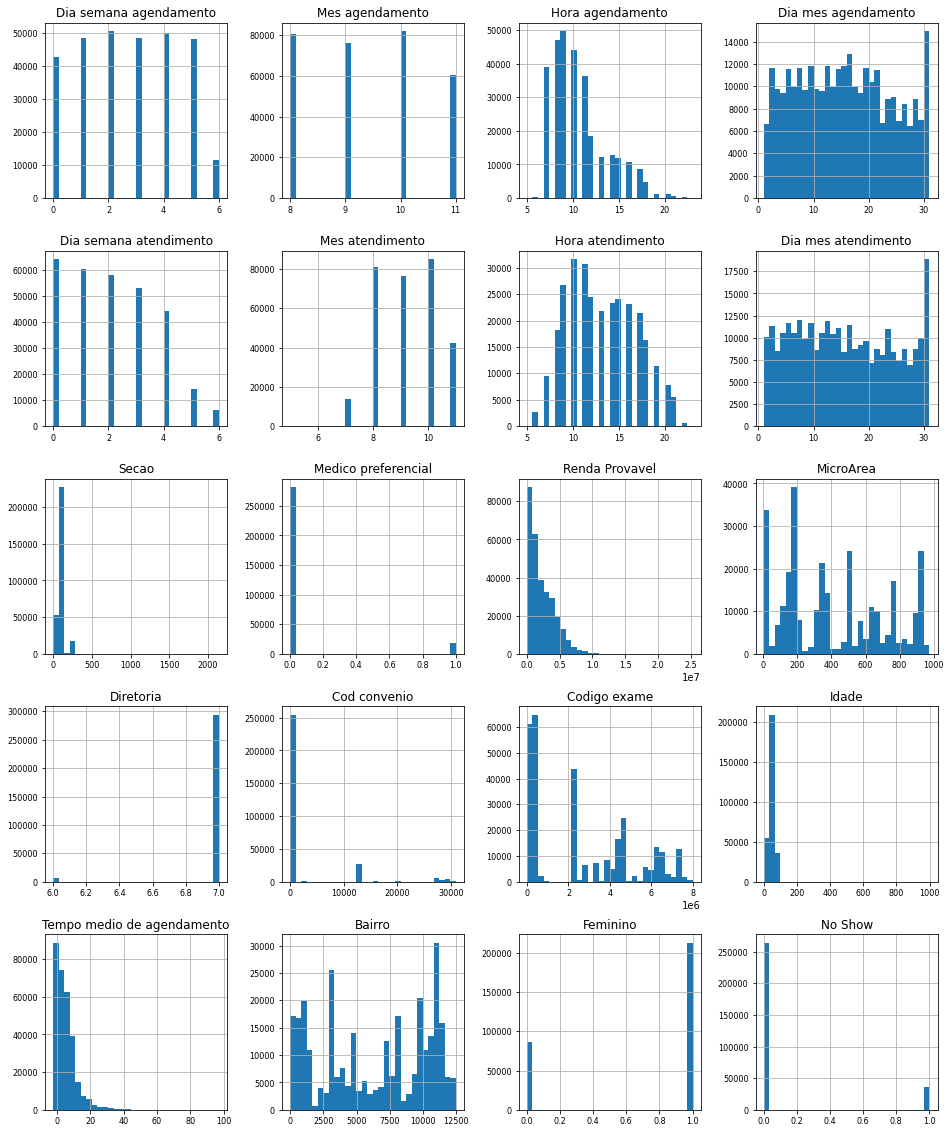

In [12]:
df.hist(figsize=(16, 20),bins=30, xlabelsize=8, ylabelsize=8);

In [13]:
df.columns

Index(['Dia semana agendamento', 'Mes agendamento', 'Hora agendamento',
       'Dia mes agendamento', 'Dia semana atendimento', 'Mes atendimento',
       'Hora atendimento', 'Dia mes atendimento', 'Secao',
       'Medico preferencial', 'Renda Provavel', 'MicroArea', 'Diretoria',
       'Cod convenio', 'Codigo exame', 'Idade', 'Tempo medio de agendamento',
       'Unidade', 'Bairro', 'Feminino', 'No Show'],
      dtype='object')

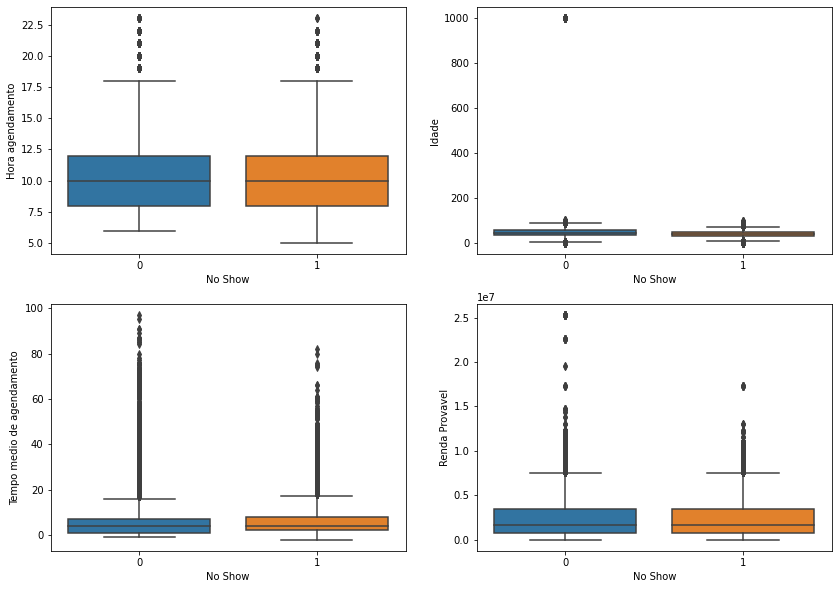

In [14]:
f, axes = plt.subplots(2,2,figsize = (14,10))
for i,col in enumerate(['Hora agendamento', 'Idade', 'Tempo medio de agendamento','Renda Provavel']):
    sns.boxplot(x='No Show',y=col,data=df,ax=axes[i//2,i%2])

In [15]:
def removing_outliers(data,col):
    Q1=data[col].quantile(0.25)
    Q3=data[col].quantile(0.75)
    IQR=Q3-Q1
    lb = Q1-1.5*IQR
    ub = Q3+1.5*IQR
    data = data[(data[col]>lb)&(data[col]<ub)]
    return data

In [16]:
for col in ['Hora agendamento', 'Idade', 'Renda Provavel']:
    df = removing_outliers(df,col)

In [17]:
df = df[df['Tempo medio de agendamento']>=0]

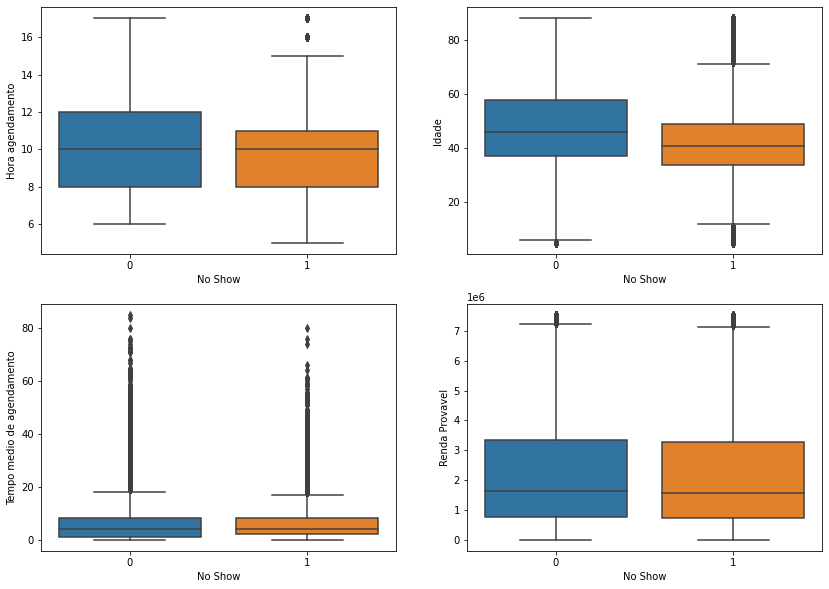

In [18]:
f, axes = plt.subplots(2,2,figsize = (14,10))
for i,col in enumerate(['Hora agendamento', 'Idade', 'Tempo medio de agendamento','Renda Provavel']):
    sns.boxplot(x='No Show',y=col,data=df,ax=axes[i//2,i%2])

In [19]:
columns_dates = ['Dia semana agendamento', 'Mes agendamento', 'Dia mes agendamento',
                 'Dia semana atendimento', 'Mes atendimento','Dia mes atendimento']

In [20]:
for col in columns_dates:
    df[col] = df[col].apply(lambda x: str(x) if len(str(x))!=1 else f'0{x}')

In [21]:
df[columns_dates].head()

,Dia semana agendamento,Mes agendamento,Dia mes agendamento,Dia semana atendimento,Mes atendimento,Dia mes atendimento
0,06,08,18,03,08,15
1,02,11,06,00,11,04
2,05,08,31,03,08,15
3,04,09,27,04,09,27
4,04,10,11,01,10,01


In [22]:
def time_passed(x):
    x['scheduling'] = pd.to_datetime(x['Dia mes agendamento']+'-'+x['Mes agendamento']+'-2019',format='%d-%m-%Y')
    x['due_date'] = pd.to_datetime(x['Dia mes atendimento']+'-'+x['Mes atendimento']+'-2019',format='%d-%m-%Y')
    val = x['due_date'] - x['scheduling']
    return int(val.days)

In [23]:
df['tempo_decorrido'] = df.apply(time_passed,axis=1)

In [24]:
df['tempo_decorrido'].unique()

array([ -3,  -2, -16,   0, -10, -14,  -1,  -6,  -7,  -5,  -8, -13, -12,
        -9, -17,  -4, -21, -22, -11, -27, -33, -26, -30, -24, -18, -29,
       -25, -23, -52, -38, -28, -19, -32, -42, -20, -15, -34, -37, -35,
       -45, -31, -39, -48, -36, -56, -44, -40, -41, -43, -51, -50, -55,
       -53, -46, -47, -63, -76, -58, -64, -54, -49, -66, -65, -59, -75,
       -62, -81, -67, -74, -61, -57, -69, -72, -73, -85, -80, -77, -84,
       -68], dtype=int64)

In [25]:
df['tempo_decorrido'] = df['tempo_decorrido']*-1

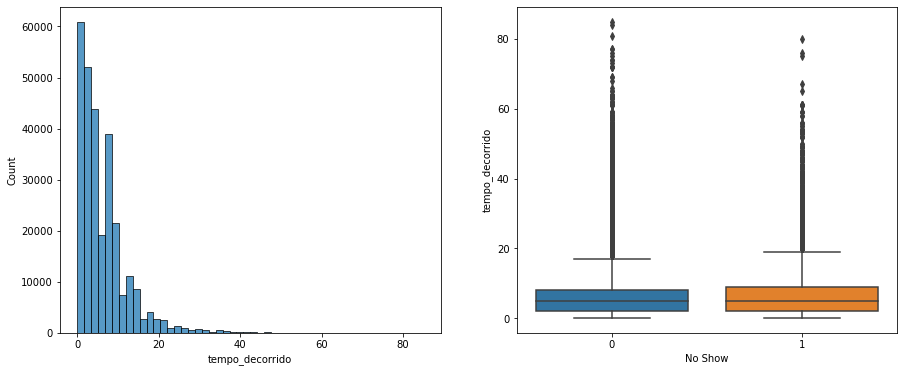

In [26]:
f, axes = plt.subplots(1,2,figsize = (15,6))
sns.histplot(data=df['tempo_decorrido'],ax=axes[0],bins=50)
sns.boxplot(x='No Show',y='tempo_decorrido',data=df,ax=axes[1]);

In [27]:
for col in ['Hora agendamento','Hora atendimento']:
    print(df[col].value_counts())
    print('-----------------------------------------------------------------')

9     48409
8     46013
10    42850
7     38213
11    35340
12    17809
14    12229
13    11706
15    11524
16    10242
17     8241
6       281
5         2
Name: Hora agendamento, dtype: int64
-----------------------------------------------------------------
10    30104
11    29103
9     25361
12    23173
15    22657
14    21957
16    21700
13    20545
17    20098
8     17282
18    15315
19    10771
7      9093
20     7361
21     5212
6      2619
22      490
5        14
23        4
Name: Hora atendimento, dtype: int64
-----------------------------------------------------------------


In [28]:
def encode_appointment_time(x):
    if x <= 10:
        return 'early morning'
    elif x <= 14:
        return 'midday'
    elif x <= 18:
        return 'afternoon'
    else:
        return 'night'

In [29]:
for col in ['Hora agendamento','Hora atendimento']:
    df[col] = df[col].apply(encode_appointment_time)

In [30]:
for col in df.columns:
    if col not in ['Idade', 'Tempo medio de agendamento','Renda Provavel','tempo_decorrido']:
        print(df[col].value_counts())
        print('-----------------------------------------------------------------')

02    47435
04    47235
05    46686
03    45379
01    45375
00    39642
06    11107
Name: Dia semana agendamento, dtype: int64
-----------------------------------------------------------------
10    77420
08    76262
09    72027
11    57150
Name: Mes agendamento, dtype: int64
-----------------------------------------------------------------
early morning    175768
midday            77084
afternoon         30007
Name: Hora agendamento, dtype: int64
-----------------------------------------------------------------
16    12307
15    11245
12    11166
09    11152
02    10995
19    10976
14    10924
05    10916
07    10902
21    10816
20     9878
13     9415
17     9380
06     9305
10     9289
03     9232
08     9101
11     8973
18     8873
04     8805
24     8616
28     8469
23     8195
30     8116
26     7995
29     6559
25     6525
22     6314
01     6248
27     6165
31     6007
Name: Dia mes agendamento, dtype: int64
-----------------------------------------------------------------
00  

In [31]:
df.dtypes

Dia semana agendamento        object
Mes agendamento               object
Hora agendamento              object
Dia mes agendamento           object
Dia semana atendimento        object
Mes atendimento               object
Hora atendimento              object
Dia mes atendimento           object
Secao                          int64
Medico preferencial            int64
Renda Provavel                 int64
MicroArea                      int64
Diretoria                      int64
Cod convenio                   int64
Codigo exame                   int64
Idade                          int64
Tempo medio de agendamento     int64
Unidade                       object
Bairro                         int64
Feminino                       int64
No Show                        int64
tempo_decorrido                int64
dtype: object

In [162]:
to_string = ['Secao','MicroArea','Diretoria','Cod convenio','Codigo exame','Bairro']

In [33]:
for col in to_string:
    df[col] = df[col].apply(str)

In [34]:
columns_encode = ['Cod convenio','MicroArea','Codigo exame','Bairro']

In [35]:
dict_encode = {}
for col in columns_encode:
    dict_encode[col] = dict(df[col].value_counts())

In [36]:
for col in df.columns:
    if col not in ['Idade', 'Tempo medio de agendamento','Renda Provavel','tempo_decorrido']:
        print(df[col].value_counts())
        print('-----------------------------------------------------------------')

02    47435
04    47235
05    46686
03    45379
01    45375
00    39642
06    11107
Name: Dia semana agendamento, dtype: int64
-----------------------------------------------------------------
10    77420
08    76262
09    72027
11    57150
Name: Mes agendamento, dtype: int64
-----------------------------------------------------------------
early morning    175768
midday            77084
afternoon         30007
Name: Hora agendamento, dtype: int64
-----------------------------------------------------------------
16    12307
15    11245
12    11166
09    11152
02    10995
19    10976
14    10924
05    10916
07    10902
21    10816
20     9878
13     9415
17     9380
06     9305
10     9289
03     9232
08     9101
11     8973
18     8873
04     8805
24     8616
28     8469
23     8195
30     8116
26     7995
29     6559
25     6525
22     6314
01     6248
27     6165
31     6007
Name: Dia mes agendamento, dtype: int64
-----------------------------------------------------------------
00  

In [37]:
for key in dict_encode.keys():
    df[key] = df[key].apply(lambda x: 'others' if dict_encode[key][x]<=5 else x)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('No Show',axis=1), df['No Show'], 
                                                    test_size=0.33, random_state=42,stratify=df['No Show'])

In [39]:
te = TargetEncoder()

In [40]:
X_train_te = te.fit_transform(X_train.select_dtypes('object'),y_train)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [41]:
X_train = pd.merge(X_train.drop(X_train_te.columns,axis=1),X_train_te,how='left',left_index=True,right_index=True)

In [42]:
X_test_te = te.transform(X_test.select_dtypes('object'))

In [43]:
X_test = pd.merge(X_test.drop(X_test_te.columns,axis=1),X_test_te,how='left',left_index=True,right_index=True)

In [44]:
def ks_stat(y, yhat):
    return ks_2samp(yhat[y==1], yhat[y!=1]).statistic  
ks_scorer = make_scorer(ks_stat, needs_proba=True,greater_is_better=True)

In [45]:
class HyperoptObjective(object):
    def __init__(self, X, y, model, const_params, fit_params, cv_splitter, cv_scoring, calibration):
        self.evaluated_count = 0
        self.X = X
        self.y = y
        self.model = model
        self.constant_params = const_params
        self.fit_params = fit_params
        self.cv_splitter = cv_splitter
        self.cv_scoring = cv_scoring
        self.calibration = calibration
        
    def __call__(self, hyper_params):
        
        if self.calibration == None:
            cv_result = cross_validate(
                self.model(**hyper_params, **self.constant_params),
                self.X, 
                self.y, 
                scoring=self.cv_scoring,
                cv=self.cv_splitter,
                fit_params=self.fit_params,
                return_train_score=True
            )

            mean_cv_result = np.mean(cv_result['test_score'])

            self.evaluated_count += 1

        else:  
            X_treino, X_teste, y_treino, y_teste = train_test_split(self.X, self.y, test_size=0.20,
                                                                    random_state= np.random.randint(15,15115154),
                                                                    stratify=self.y)
            clb_clf = CalibratedClassifierCV(base_estimator=self.model(**hyper_params, **self.constant_params),
                                             cv= self.cv_splitter,method=self.calibration)
            clb_clf.fit(X_treino,y_treino)
            proba = clb_clf.predict_proba(X_teste)[:,1]
            mean_cv_result = ks_stat(y_teste,proba)
            self.evaluated_count += 1
        
        if self.cv_scoring._sign > 0:
            mean_cv_result = -mean_cv_result
                
        return mean_cv_result

In [46]:
def find_best_params(X, 
                     y, 
                     X_test,
                     y_test,
                     model,
                     const_params, 
                     parameter_space, 
                     fit_params={},
                     max_evals=25,
                     cv_splitter=None,
                     cv_scoring=None,
                    calibration=None):
    
    objective = HyperoptObjective(X, y, model, const_params, 
                                  fit_params, cv_splitter, cv_scoring,calibration)
    trials = hyperopt.Trials()
    
    best_params = hyperopt.fmin(
        fn=objective,
        space=parameter_space,
        algo=hyperopt.tpe.suggest,
        rstate=np.random.RandomState(seed=42),
        max_evals=max_evals,
        trials=trials
    )
      
    best_params.update(const_params)
       
    n_estimators_list = [i for i in range(50, 251, 25)]
    max_depth_list = [i for i in range(3, 11)]
    min_child_samples_list = [i for i in range(1, 30)]
    booster_list = ['Plain','Ordered']
       
    
    best_params['n_estimators'] = n_estimators_list[best_params['n_estimators']]
    best_params['max_depth'] = max_depth_list[best_params['max_depth']]
    best_params['min_child_samples'] = min_child_samples_list[best_params['min_child_samples']]
    best_params['boosting_type'] = booster_list[best_params['boosting_type']]

    
    print(best_params)

    if calibration is None:
        clf = CatBoostClassifier(**best_params)
        clf.fit(X,y,**fit_params)
    else:
        clf_base = CatBoostClassifier(**best_params)
        clf = CalibratedClassifierCV(base_estimator=clf_base,cv=cv_splitter,method=calibration)
        clf.fit(X,y)
        
    proba = clf.predict_proba(X_test)[:,1]
    ks_test = ks_stat(y_test,proba)
    cr = classification_report(y_test,clf.predict(X_test))
    print(f'\tKS value for OOT subset: {ks_test}')
    print(f'\t{cr}\n')
    
    return best_params, trials, clf, ks_test, cr

In [47]:
def train_model(X,y,X_test,y_test,n_splits_range,k_range,eval_metric,cal,name_pickle):
    
    const_params = {
    'silent': True,
    'thread_count': 8,
    'od_pval':0.01}
    
    parameter_space = {
        'n_estimators': hyperopt.hp.choice('n_estimators', np.arange(50, 250, 25)),
        'max_depth': hyperopt.hp.choice('max_depth', np.arange(3, 10)),
        'learning_rate': hyperopt.hp.uniform('learning_rate', 0.01, 0.25),
        'reg_lambda': hyperopt.hp.uniform('reg_lambda', 1, 10),
        'scale_pos_weight': hyperopt.hp.uniform('scale_pos_weight', 1, 50),
        'eval_metric':'F1',
        'random_strength':hyperopt.hp.uniform('random_strength', 0.01, 10),
        'boosting_type':hyperopt.hp.choice('boosting_type', ['Plain','Ordered']),
        'colsample_bylevel': hyperopt.hp.uniform('colsample_bylevel', 0.2, 1),
        'min_child_samples': hyperopt.hp.choice('min_child_samples', np.arange(1, 30)),
        'subsample': hyperopt.hp.uniform('subsample', 0.3, 1)}

    fit_params = {
        'cat_features': None,
         'sample_weight':None}
    
    
    best_params = {}
    try:
        del parameter_space['eval_metric']
    except:
        pass
    parameter_space['eval_metric'] = eval_metric
    
    for n_splits in n_splits_range:
        for k in k_range:
            print(f'resultados_com_splits_{n_splits}_evals_{k}')
            best_params_model, trials, clf, ks, cr = find_best_params(X.fillna(0),y,
                X_test.fillna(0),y_test,CatBoostClassifier,
                const_params,
                parameter_space,
                fit_params,
                max_evals=k,
                cv_splitter=StratifiedKFold(n_splits=n_splits),
                cv_scoring=ks_scorer,
                calibration = cal)
            best_params[f'resultados_com_splits_{str(n_splits)}_evals{str(k)}'] = \
                                (best_params,clf,min(trials.losses()),ks,cr)
            pickle.dump(best_params,open(f'{name_pickle}.pickle','wb'))
    return best_params

In [51]:
best_params_f1 = train_model(X_train,y_train,X_test,y_test,range(3,4),range(30,31),
                              'F1',None,'best_params_f1')

resultados_com_splits_3_evals_30
100%|██████████████████████████████████████████████| 30/30 [10:35<00:00, 21.18s/trial, best loss: -0.39350789556654037]
{'boosting_type': 'Plain', 'colsample_bylevel': 0.9761661541717239, 'learning_rate': 0.19849919629219204, 'max_depth': 9, 'min_child_samples': 16, 'n_estimators': 200, 'random_strength': 6.223711177637753, 'reg_lambda': 1.3655865871352197, 'scale_pos_weight': 22.399368406679663, 'subsample': 0.39098774778232176, 'silent': True, 'thread_count': 8, 'od_pval': 0.01}
	KS value for OOT subset: 0.3942712314446969
	              precision    recall  f1-score   support

           0       0.96      0.42      0.59     82255
           1       0.17      0.87      0.28     11089

    accuracy                           0.47     93344
   macro avg       0.56      0.65      0.43     93344
weighted avg       0.87      0.47      0.55     93344




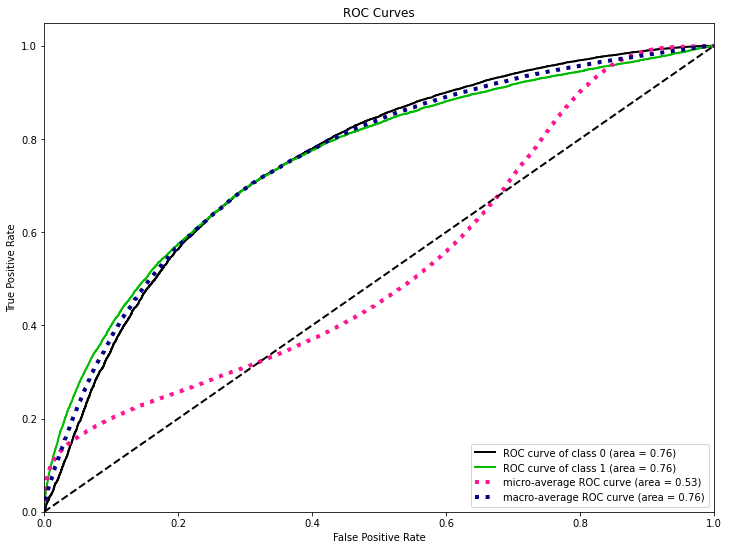

In [108]:
def plot_auc(X,y,clf):
    skplt.metrics.plot_roc(y, clf.predict_proba(X.fillna(0)),figsize=(12,9))
plot_auc(X_test,y_test,best_params_f1[list(best_params_f1.keys())[0]][1])

In [103]:
def plot_ks(X,y,clf):
    skplt.metrics.plot_ks_statistic(y, clf.predict_proba(X.fillna(0)),figsize=(12,9))
    plt.xlabel('Threshold', fontsize=15)
    plt.ylabel('Proporção abaixo do threshold', fontsize=15)
    plt.title('Gráfico do Estatístico KS',fontsize=17)
    plt.legend(fontsize=12);
    plt.show()

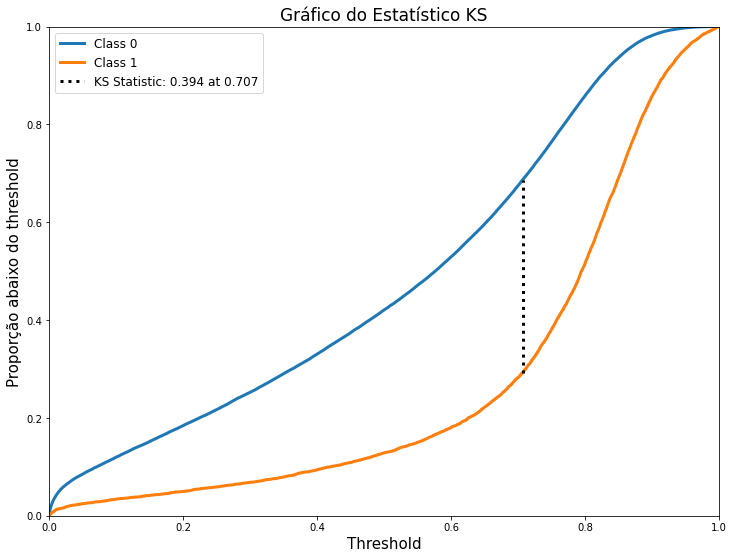

In [105]:
plot_ks(X_test,y_test,best_params_f1[list(best_params_f1.keys())[0]][1])

In [117]:
def filter_approved(df,clf,q):      
    df['predicao'] = clf.predict_proba(df)[:,1]
    df['quantil'] = pd.qcut(df['predicao'], q=q)
    return df

In [120]:
def quantiles(df_org,indx,col,val,clf,q=20,return_df=False): 
    df = df_org.copy()
    df = filter_approved(df,clf,q)
    df_aux = pd.pivot_table(df,index=indx,
                  columns = col,values=val,aggfunc='count').fillna(0).reset_index()
    df_aux.columns = ['dropar','bom','bad']
    df_aux.drop('dropar',axis=1,inplace=True)
    df_aux['precision_per_group'] = df_aux['bad']/(df_aux['bad']+df_aux['bom'])
    df_aux['recall_per_group'] = df_aux['bad']/df[col].sum()
    if return_df:
        return df_aux,df
    else:
        return df_aux

In [123]:
df_analysys,df_predict = quantiles(pd.merge(X_test,y_test,left_index=True,right_index=True),'quantil','No Show','Bairro',
          best_params_f1[list(best_params_f1.keys())[0]][1],q=20,return_df=True)
df_analysys

,bom,bad,precision_per_group,recall_per_group
0,4498,170,0.036418,0.015331
1,4500,167,0.035783,0.015060
2,4509,158,0.033855,0.014248
3,4501,166,0.035569,0.014970
4,4505,162,0.034712,0.014609
5,4463,204,0.043711,0.018397
6,4451,217,0.046487,0.019569
7,4424,243,0.052068,0.021914
8,4380,287,0.061496,0.025882
9,4368,299,0.064067,0.026964


In [127]:
min_proba = df_predict['predicao'][df_predict['quantil'] == sorted(df_predict['quantil'].unique())[13]].min()
min_proba

0.7130678966453113

In [128]:
print(classification_report(df_predict['No Show'],df_predict['predicao'].apply(lambda x: 0 if x < min_proba else 1)))

              precision    recall  f1-score   support

           0       0.94      0.70      0.80     82255
           1       0.24      0.70      0.35     11089

    accuracy                           0.70     93344
   macro avg       0.59      0.70      0.58     93344
weighted avg       0.86      0.70      0.75     93344



In [84]:
def plot_shap(clf,data,target):
    explainer = shap.TreeExplainer(clf) 
    shap_values = explainer.shap_values(Pool(data.tail(5000)[clf.feature_names_],target.tail(5000)))
    shap.summary_plot(shap_values,data.tail(5000)[clf.feature_names_])

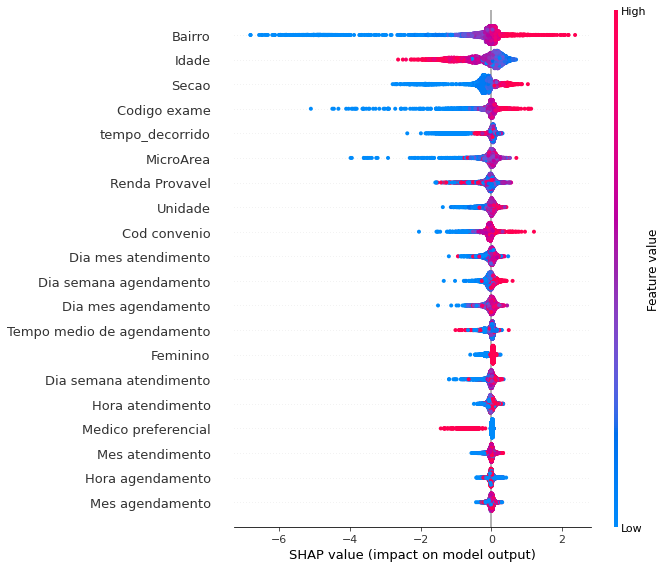

In [85]:
plot_shap(best_params_f1[list(best_params_f1.keys())[0]][1],X_test,y_test)

In [260]:
stats.ttest_ind(df.Idade[df['No Show']==0],df.Idade[df['No Show']==1],equal_var=False)

Ttest_indResult(statistic=61.30911909782914, pvalue=0.0)

In [264]:
pointbiserialr(df['No Show'],df.Idade)

PointbiserialrResult(correlation=-0.10678140322449817, pvalue=0.0)

In [265]:
stats.ttest_ind(df.tempo_decorrido[df['No Show']==0],df.tempo_decorrido[df['No Show']==1] , equal_var=False)

Ttest_indResult(statistic=-11.94945717629162, pvalue=7.377849883561667e-33)

In [266]:
pointbiserialr(df['No Show'],df['tempo_decorrido'])

PointbiserialrResult(correlation=0.023045675213183417, pvalue=1.5165061246922713e-34)

In [97]:
df_jaccard = pd.get_dummies(df[['Bairro','Secao','Codigo exame','No Show']])
df_jaccard.head()

,No Show,Bairro_1,Bairro_10004,Bairro_10013,Bairro_10019,Bairro_10021,Bairro_10024,Bairro_10029,Bairro_10037,Bairro_10049,...,Codigo exame_7931040,Codigo exame_7931430,Codigo exame_7931560,Codigo exame_7931820,Codigo exame_7932210,Codigo exame_843440,Codigo exame_853580,Codigo exame_8970,Codigo exame_963560,Codigo exame_others
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
jaccard_score_result = {col:jaccard_score(df_jaccard['No Show'],df_jaccard[col]) for col in df_jaccard.columns[1:]}

In [146]:
jaccard_score_result = pd.DataFrame({'variable':list(jaccard_score_result.keys()),
                                     'jaccard_score':list(jaccard_score_result.values())})

In [147]:
jaccard_score_result.sort_values(by='jaccard_score',ascending=False).head(30)

,variable,jaccard_score
2382,Secao_110,0.088879
2525,Codigo exame_465530,0.078218
2392,Secao_22,0.064668
2437,Codigo exame_2376530,0.059492
2409,Secao_98,0.052872
2408,Secao_96,0.049181
2395,Secao_240,0.042360
2385,Secao_122,0.040427
2499,Codigo exame_4317950,0.039554
2402,Secao_68,0.038757


### Pipeline de Classificação

In [230]:
clf = pickle.load(open('best_classifier.pickle','rb'))
te = pickle.load(open('target_encoder.pickle','rb'))
df_data = pd.read_csv(r"C:\Users\mf_ra\OneDrive\Escritorio\case_fleury\dataset.txt",sep=";")
dict_encode = pickle.load(open('dict_encode.pickle','rb'))

In [231]:
def encode_appointment_time(x):
    if x <= 10:
        return 'early morning'
    elif x <= 14:
        return 'midday'
    elif x <= 18:
        return 'afternoon'
    else:
        return 'night'

In [232]:
def time_passed(x):
    x['scheduling'] = pd.to_datetime(x['Dia mes agendamento']+'-'+x['Mes agendamento']+'-2019',format='%d-%m-%Y')
    x['due_date'] = pd.to_datetime(x['Dia mes atendimento']+'-'+x['Mes atendimento']+'-2019',format='%d-%m-%Y')
    val = x['due_date'] - x['scheduling']
    return abs(int(val.days))

In [233]:
def scoredata(data,clf,te,dict_encode):
    
    ### Preenchimento de nulos
    
    for col in data.columns:
        if data[col].isnull().any():
            try:
                data[col].fillna(data[col].median(),inplace=True)
            except:
                data[col].fillna(data[col].mode(),inplace=True)
    
    ### Calculo do tempo decorrido
   
    columns_dates = ['Dia semana agendamento', 'Mes agendamento', 'Dia mes agendamento',
                 'Dia semana atendimento', 'Mes atendimento','Dia mes atendimento']
    
    for col in columns_dates:
        data[col] = data[col].apply(lambda x: str(x) if len(str(x))!=1 else f'0{x}')

    data['tempo_decorrido'] = data.apply(time_passed,axis=1)
    
    
    ### Selecionando só as features que preciso
    
    data = data[clf.feature_names_]
    
    ### Aplicando discretizacao de horário
            
    for col in ['Hora agendamento','Hora atendimento']:
        data[col] = data[col].apply(float)
        data[col] = data[col].apply(encode_appointment_time)

       
    ### Aplicando target_encoder
    
    to_string = ['Secao','MicroArea','Diretoria','Cod convenio','Codigo exame','Bairro']
    for col in to_string:
        data[col] = data[col].apply(str)
        
    for key in dict_encode.keys():
        data[key] = data[key].apply(lambda x: 'others' if dict_encode[key][x]<=5 else x)
           
    data_encoded = te.transform(data[te.cols])

    data = pd.merge(data.drop(data_encoded.columns,axis=1),data_encoded,how='left',left_index=True,right_index=True)
    
    ### Predicoes
    data['no_show_proba'] = clf.predict_proba(data)[:,1]
    data['no_show_target'] = data['no_show_proba'].apply(lambda x: 0 if x < 0.7130678966453113 else 1)
    return data

# Explicação



Ao fazer a análise exploratória foi percebida a existência de pequenas inconsistências que foram efetivamente ajustadas para melhorar a interpretação dos dados.

O primeiro step consistiu em avaliar as variáveis que estavam dentro do dataset para verificar seu formato, critério, distribuição e a existência de dados faltantes. Comprovamos que algumas colunas não adicionavam informação, pelo que foram removidas. Seguidamente, foi feito um tratamento sobre os outliers, onde foi aplicada a regra dos 3 desvios para eliminá-los. Este procedimento foi feito sobre as variáveis de renda, idade e hora de agendamento, uma vez que os agendamentos são feitos em horário comercial. A variável tempo de agendamento não recebeu esse mesmo tratamento uma vez que queria se validar a hipótese da incidência de longas esperas no evento 'no show'.

Procedimentos de feature engineering foram feitos para discretizar o campo 'hora agendamento' e 'hora atendimento' em manhã, meio-dia, tarde e noite segundo a hora. Em adição, foi criada a variável 'tempo_decorrido', que indica o tempo entre a consulta e a data do exame agendado. Para as variáveis categóricas como bairro, secao, tipo de exame foi aplicado um procedimento de target encoding, que consiste em calcular a proporção de vezes que a variável predita se manifesta em cada valor assumido pela variável. 

Finalmente, e seguindo uma regra geral, todas aquelas observações com frequência menor do que 5 foram agrupadas em uma mesma classe (other) para cada variável categórica. 

Os dados foram separados entre treino e teste, onde 2/3 dos dados foram selecionados para treinar o modelo. Cabe adicionar que o target encoder foi treinado com os dados de treino e não com o dataset completo para evitar o efeito de target leakage.

Assim, foi escolhido o CatBoostClassifier como modelo a ser utilizado para treinar e fazer as predições. Dentre os motivos para sua escolha encontram-se a rapidez do treino, a facilidade de usar em conjunto com outras libraries como sklearn, sua boa documentação e a possibilidade de criar ponderações artificiais para classe em caso de desbalanceamento (parâmetro scale_pos_weight), aplicável para o problema em questão. Em adição, este algoritmo permite definir uma métrica de avaliação a ser aprimorada após cada iteração; no caso foi escolhido o F1-score. 

A seleção dos hiperparâmetros foi feita em conjunto com hyperopt, componente baseado em otimização bayesiana para escolher os melhores hipeparâmetros com base nas escolhas prévias. A função objetivo do hyperopt foi o KS, métrica utilizada nos testes de bondade de ajuste para avaliar se duas variáveis tem uma distribuição similar. Um valor igual a 1 indica que ambas são separáveis, pelo que o nosso objetivo é maximizar o valor do KS (ou minimizar o valor do KS negativo).

Após o treino encontramos que as métricas reportadas em termos de F1-score, precision, recall, acurácia e AUC foram favoráveis, assim que se procedeu a fazer uma análise por vintil de predição, olhando para o precision e recall por grupo para achar o melhor threshold de separação entre as classes. Assim, decidiu-se que o melhor ponto de corte estava no grupo 13, com uma probabilidade de no show do 71%. 

Finalizada a modelagem, foram utilizados os shap values para determinar quais eram as variáveis que mais discriminaram na predição do evento no grupo de teste. Encontramos que o maior preditor foi o bairro de residência do paciente, sendo os bairros 4826 e 3077 os de maior incidência no 'no show'. Também se percebeu que enquanto maior é a idade do paciente, maior a chance de comparecer no exame agendado. Em seguida, seção, tipo de exame e o tempo entre a consulta e o agendamento foram as seguintes preditoras mais fortes para 'no show'. Em particular, enquanto maior o tempo entre a consulta e o agendamento, maior a chance de o paciente não comparecer. 

Dentro das cinco principais preditoras, uma sobre a qual poderia se trabalhar é a de tempo entre a consulta e o agendamento. Desta forma, ao agendar exames próximos à data de consulta elevam-se as chances de o paciente comparecer. Outra ação que poderia ajudar (mas que foge do escopo deste case) seria o acionamento de lembretes um ou dois dias antes da consulta, onde seja solicitado ao paciente a confirmação ou cancelamento da consulta, assim poderiam dar a oportunidade a outros pacientes de adiantar seus exames a agilizar o processo de diagnóstico.

Considerações adicionais: algumas variáveis adicionais teriam enriquecido o estudo, como por exemplo, indicadores se era o primeiro exame do paciente ou se era exame periódico, se tratava-se de um paciente com comorbidades, doença terminal ou paciente esporádico. Outras variáveis que poderiam ter ajudado seria a proximidade dos pacientes ao respeito do local de exames, assim como uma variável que indicasse se o paciente manifestou algum 'no show' numa janela móvel de 6 meses. A construção de variáveis temporais ou de sazonalidade indicando se era começo do mês, final de semana, etc, também poderiam ter aumentado o poder de predição.

Para ter resultados ainda mais satisfatórios, poderia se desenvolver um modelo por cada região de interesse (ou por unidade de atendimento). Assim haveria um ganho de granularidade embora se perdesse a interoperabilidade global de fatores.